# K-Nearest Neighbors Classifier

# Setup
Let us import the required modules.

In [1]:
import pandas as pd
import seaborn as sns

from loguru import logger
from sklearn.metrics import accuracy_score

from src.classifiers.knn import KNN
import src.utilities.data_split as ds
import src.utilities.evaluation as eva
import src.utilities.model_selection as ms

## Load Data
Note that the dataset is already split into Train-Test sets.

In [2]:
data_split = ds.TrainTestSplit.from_csv_directory(dir_path="../data")

In [3]:
data_split.x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 719 entries, pixel13 to pixel780
dtypes: float64(719)
memory usage: 329.1 MB


In [4]:
data_split.y_train.shape

(60000,)

## Tuning Generative Classifiers: k-NN

Use a smaller dataset due to the workload of GridSearchCV

<AxesSubplot:ylabel='count'>

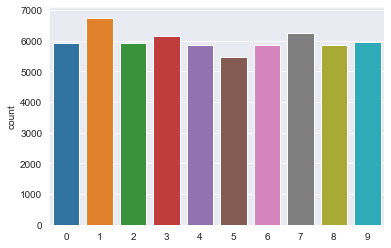

In [5]:
sns.countplot(x=data_split.y_train)

In [6]:
# x_data_small, y_data_small = ds.get_train_subset(x_train=data_split.x_train, y_train=data_split.y_train, size=5000)
x_data_small, y_data_small = ds.get_train_subset(x_train=data_split.x_train, y_train=data_split.y_train, size=1000)

<AxesSubplot:xlabel='Number', ylabel='count'>

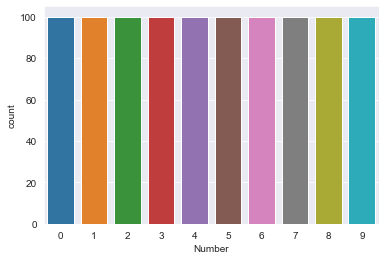

In [7]:
sns.countplot(x=y_data_small)

In [8]:
x_data_small.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 17283 to 48644
Data columns (total 719 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64

In [9]:
y_data_small.shape

(1000,)

In [10]:
y_data_small

17283    0
7243     0
13372    0
58588    0
42908    0
        ..
46756    9
47813    9
29119    9
2245     9
48644    9
Name: Number, Length: 1000, dtype: int64

## Tuning

In [11]:
# automatic parameters tuning
knnclsf=KNN()
properties={
    "k" : [5,10]
    # "n_neighbors" : [5,10,20,35,50],
    # "metric" : ['euclidean','manhattan']
}

tuned_knnclsf = ms.model_selector(estimator=knnclsf,properties=properties,scoring="accuracy",cv=10,verbose=5,jobs=4,
                                  x_train=x_data_small,y_train=y_data_small)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


2022-12-26 02:39:00.437 | INFO     | src.utilities.model_selection:model_selector:26 - --- 5.815830945968628 seconds ---
2022-12-26 02:39:00.438 | INFO     | src.utilities.model_selection:model_selector:28 - Best Score: 0.000
2022-12-26 02:39:00.439 | INFO     | src.utilities.model_selection:model_selector:29 - Best Params: 


In [12]:
# save results
ms.save_model(model=tuned_knnclsf, model_name="knn_tuning_results")

In [13]:
# to load previously saved results
tuned_knnclsf = ms.load_model("knn_tuning_results")

In [14]:
logger.info(tuned_knnclsf.cv_results_)
tuned_knnclsf_results = pd.DataFrame( tuned_knnclsf.cv_results_ )

2022-12-26 02:39:00.515 | INFO     | __main__:<module>:1 - {'mean_fit_time': array([0.02984464, 0.01793096]), 'std_fit_time': array([0.00955383, 0.00303517]), 'mean_score_time': array([0.07058682, 0.04885712]), 'std_score_time': array([0.00899142, 0.0063554 ]), 'param_k': masked_array(data=[5, 10],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'k': 5}, {'k': 10}], 'split0_test_score': array([0., 0.]), 'split1_test_score': array([0., 0.]), 'split2_test_score': array([0., 0.]), 'split3_test_score': array([0., 0.]), 'split4_test_score': array([0., 0.]), 'split5_test_score': array([0., 0.]), 'split6_test_score': array([0., 0.]), 'split7_test_score': array([0., 0.]), 'split8_test_score': array([0., 0.]), 'split9_test_score': array([0., 0.]), 'mean_test_score': array([0., 0.]), 'std_test_score': array([0., 0.]), 'rank_test_score': array([1, 1], dtype=int32), 'split0_train_score': array([0.91111111, 0.87777778]), 'split1_train_score': array([0

In [15]:
tuned_knnclsf_results[["params","mean_test_score","mean_train_score"]]

,params,mean_test_score,mean_train_score
0,{'k': 5},0.0,0.922222
1,{'k': 10},0.0,0.891333


<AxesSubplot:xlabel='param_k', ylabel='mean_test_score'>

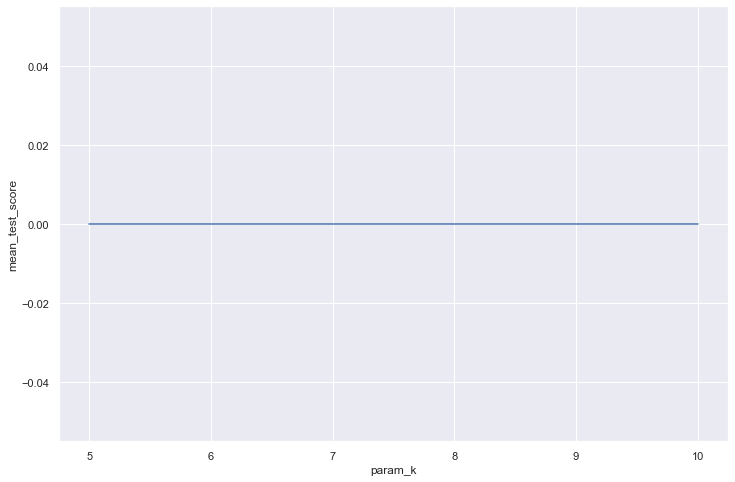

In [16]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_knnclsf_results, x="param_k", y="mean_test_score")

In [17]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_knnclsf_results, x="param_metric", y="mean_test_score")

ValueError: Could not interpret value `param_metric` for parameter `x`

In [17]:
logger.info(tuned_knnclsf.best_estimator_)
logger.info(tuned_knnclsf.best_score_)

logger.info("Best Score: {:.3f}".format(tuned_knnclsf.best_score_))
logger.info("Best Params: ", tuned_knnclsf.best_params_)

2022-12-26 02:39:01.020 | INFO     | __main__:<module>:1 - KNN(k=5)
2022-12-26 02:39:01.029 | INFO     | __main__:<module>:2 - 0.0


In [18]:
test_acc = accuracy_score(y_true = data_split.y_train,
                    y_pred = tuned_knnclsf.predict(data_split.x_train))
logger.info ("Train accuracy Score on original dataset: {}".format(test_acc) )

2022-12-26 02:39:20.771 | INFO     | __main__:<module>:3 - Train accuracy Score on original dataset: 0.8789166666666667


In [19]:
# best parameters from automatic parameters tuning
knn_clsf = KNN(**tuned_knnclsf.best_params_)
# knn_clsf = KNN(n_neighbors=10, metric="manhattan")
knn_clsf.fit(data_split.x_train, data_split.y_train)

KNN(k=5)

In [20]:
knn_try_pred = knn_clsf.predict(x_data_small)

In [21]:
logger.info('trial Accuracy Score: {}'.format(accuracy_score(y_true = y_data_small,
                                           y_pred = knn_try_pred)))
# funziona, ma ci mette 50 min se metto 10000 entries, fai meno plis, e meno modelli nel gridsearch

2022-12-26 02:39:32.507 | INFO     | __main__:<module>:1 - trial Accuracy Score: 0.972


In [ ]:
knn_train_pred = knn_clsf.predict(data_split.x_train)
knn_test_pred = knn_clsf.predict(data_split.x_test)

In [ ]:
logger.info("Training:")
logger.info('Accuracy Score: {}'.format(accuracy_score(y_true = data_split.y_train,
                                           y_pred = knn_train_pred)))

In [ ]:
logger.info("Testing:")
logger.info('Accuracy Score: {}'.format(accuracy_score(y_true = data_split.y_test,
                                           y_pred = knn_test_pred)))

------------------------------------dsadfgthyjtuyhgfsdafgh---------------------------------------------------------

# Performance

In [ ]:
knn_train_pred = knn_clsf.predict(data_split.x_train)
knn_test_pred = knn_clsf.predict(data_split.x_test)

knn_train_eval = eva.Evaluation(y_true=data_split.y_train, y_pred=knn_train_pred)
knn_test_eval = eva.Evaluation(y_true=data_split.y_test, y_pred=knn_test_pred)

In [ ]:
print("Training:")
knn_train_eval.acc_eval()
print("Testing:")
knn_test_eval.acc_eval()

accuracy is not a great measure of classifier performance when the classes are imbalanced
but as we can see from the plots, the classes are more or less balanced

In [ ]:
# save the model and evaluations
knn_model = eva.EvaluatedModel(knn_clsf, "knearestneighbors", train_eval=knn_train_eval, test_eval=knn_test_eval)
knn_model.save_evaluation()

In [ ]:
# load the previously saved model and evaluations
knn_model = eva.EvaluatedModel.load_evaluation("knearestneighbors")

### Confusion Matrix

In [ ]:
knn_model.train_eval.conf_mat()

In [ ]:
knn_model.test_eval.conf_mat()